In [35]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
import sys

sys.path.append("../")

import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from pathlib import Path
from justpfm import justpfm
from typing import List, Dict
from scipy.stats import zscore
import matplotlib.pyplot as plt

from src.utils.file import get_files_recursive, get_experiment_id_from_file_path, get_sequence_id_from_file_path

from src.config import DEPTH_MAP_PFM_PATH, DEPTH_SEG_PFM_PATH

SUBSET_RATIO = 0.001

In [37]:
def get_data() -> pd.DataFrame:
    # Get files
    depth_map_file_paths = get_files_recursive(DEPTH_MAP_PFM_PATH, "*.pfm")
    depth_map_file_paths = sorted(depth_map_file_paths)
    depth_seg_file_paths = get_files_recursive(DEPTH_SEG_PFM_PATH, "*.pfm")
    depth_seg_file_paths = sorted(depth_seg_file_paths)

    # Preallocate lists to hold the data
    sequence_ids = []
    depth_values_all = []

    # Loop over depth map files
    for depth_map_file_path, depth_seg_file_path in tqdm(zip(depth_map_file_paths, depth_seg_file_paths), desc="⌛ Loading depth maps...", total=len(depth_map_file_paths)):
        # Get experiment and sequence information
        experiment_id = get_experiment_id_from_file_path(depth_map_file_path)
        sequence_id = get_sequence_id_from_file_path(depth_map_file_path)

        # Only take experiment 1
        if experiment_id != 1:
            continue
        
        # Get depth map values, not including sky and foreground
        depth_map = justpfm.read_pfm(depth_map_file_path)
        depth_seg = justpfm.read_pfm(depth_seg_file_path)
        sky_mask = depth_seg == 0
        foreground_mask = depth_seg == np.max(depth_seg)
        depth_values = depth_map[~sky_mask & ~foreground_mask].flatten()

        # Store values in the preallocated lists
        sequence_ids.extend([sequence_id] * len(depth_values))
        depth_values_all.extend(depth_values)

    print(f"✅ Loaded {len(depth_map_file_paths):,} depth maps.")

    # Create a DataFrame in one go
    data = pd.DataFrame({
        "sequence_id": sequence_ids,
        "depth_value": depth_values_all,
    })

    print(f"✅ Created dataframe with {len(data):,} depth values.")

    # Remove outliers using z-score for each sequence
    grouped_data = data.groupby(["sequence_id"])
    processed_data = []
    for sequence_id, group in grouped_data:
        # Remove outliers
        group_filtered = group[np.abs(zscore(group['depth_value'])) < 3].copy()

        processed_data.append(group_filtered)
    processed_data = pd.concat(processed_data)

    print(f"✅ Removed outliers using z-score and normalizing, keeping {len(processed_data):,} values.")

    return processed_data

data = get_data()

⌛ Loading depth maps...: 100%|██████████| 50/50 [00:02<00:00, 22.29it/s]


✅ Loaded 50 depth maps.
✅ Created dataframe with 35,296,237 depth values.
✅ Removed outliers using z-score and normalizing, keeping 35,140,217 values.


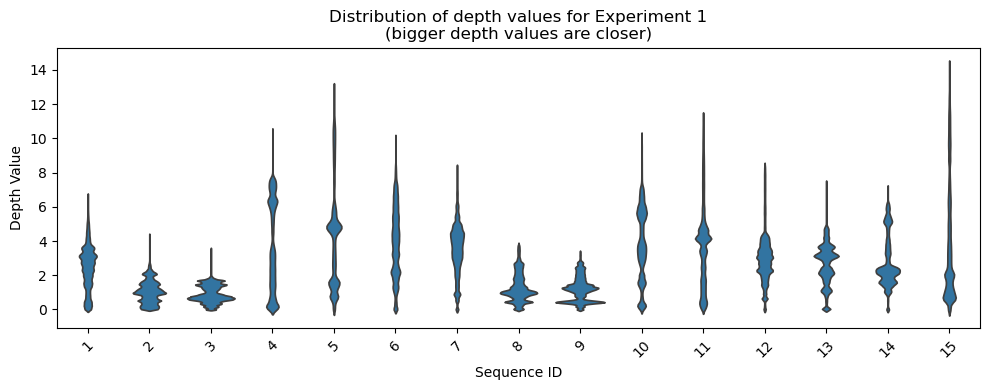

In [38]:
def plot_violin_depth_values(data: pd.DataFrame) -> None:
    n_sequences = data['sequence_id'].nunique()
    plt.figure(figsize=(int(n_sequences / 1.5), 4))
    sns.violinplot(x='sequence_id', y='depth_value', data=data, inner=None)
    plt.title(f'Distribution of depth values for Experiment 1\n(bigger depth values are closer)')
    plt.xlabel('Sequence ID')
    plt.ylabel('Depth Value')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_violin_depth_values(data)